<a href="https://colab.research.google.com/github/laggyperson/URAP-Sumo-Data-Collection/blob/main/RNN_%2B_LSTM_%2B_Time_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About
This notebook contains both notes on how to use LSTMs and the actual model I will be training with.

Link to Tutorials Followed:
1. Pytorch LSTM: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
2. Uses TF extension: https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf
3. TF LSTM documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
4. TF Time Series Tutorial: https://www.tensorflow.org/tutorials/structured_data/time_series
5. Using LSTM for time series: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Other Useful Links:
1. Attention: https://stackoverflow.com/questions/58966874/adding-attention-on-top-of-simple-lstm-layer-in-tensorflow-2-0
2.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Introduction

In [2]:
# Just testing LSTM layer
time_series = tf.random.normal([100, 2, 3])
model = tf.keras.models.Sequential([
    layers.Embedding(input_dim=1000, output_dim=64),
    layers.LSTM(128),
    layers.Dense(10),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


Layer Types:
* Simple RNN - fully connected RNN; output of previous fed into current
* GRU - Gates Recurrences Unit; less memory and faster, but less accurate for longer datasets
* LSTM

Some useful parameters for each layer:
* `return_sequences=True ` : output of the layer will be `(batch_size, timesteps, units)`
* `return_state=True` : returns the internal state of the layer for continuing later or replicating layer
  * LSTM has 2 state tensors, GRU has 1
* `initial_state` : set the initial staet of the layer

In [6]:
# Example of states and LSTM
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     64000       ['input_3[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, None, 64)     128000      ['input_4[0][0]']                
                                                                                              

You can work with individual cells instead of an entire layer: can get more fine tune control

`RNN(LSTMCell(10)) == LSTM(10)`, except that the layer uses CuDNN (Nvidia's Cuda technology that uses GPU for training, which is faster)

There are 3 cells: SimpleRNNCell, GRUCell, and LSTMCell

# Cross-batch statefulness

Goal: Some sequences are split across batches and we want the internal state of the RNN layer to stay the same across several batches

Just set the layer's `stateful` parameter to `True`

An example of how you would process the data is
```
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

For a batch of sequences, the `i`th sequence in the batch must be continued in the `i`th position in the next batch: would likely drop remainders when batching.

In [10]:
# Example:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()

In [ ]:
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

# Grabbing existing state
existing_state = lstm_layer.states

# Using the state
new_lstm_layer = layers.LSTM(64)
# This essentially continues the model from where it left off
new_output = new_lstm_layer(paragraph3, intial_state=existing_state)

# Performance Optimization and CuDNN Kernels
I am using version 2.x, which has CuDNN kernel built in **under the assumption** that:
* The `activation` function is `tanh`
* The `recurrent_activation` is `sigmoid`
* The `recurrent_dropout == 0`
* `unroll == False` (no loop unrolling)
* `use_bias == True`
* Masking on strictly right padded data

**NOTE:** This only works if you have an Nvidia GPU, else it is actually slower if it is on.

Below demonstrates the performance differences

In [11]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [13]:
# Loading Data
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # Normalization
sample, sample_label = x_train[0], y_train[0]

11490434/11490434 [==============================] - 0s 0us/step


In [21]:
# Output will be [batch_size, 10]
# Each length 10 vector will hold an integer from 0-9
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 25s 24ms/step - loss: 0.9379 - accuracy: 0.7036 - val_loss: 0.5097 - val_accuracy: 0.8441


In [20]:
# No CuDNN
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 23s 23ms/step - loss: 0.3858 - accuracy: 0.8832 - val_loss: 1.1235 - val_accuracy: 0.6676


Predicted result is: [3], target result is: 5


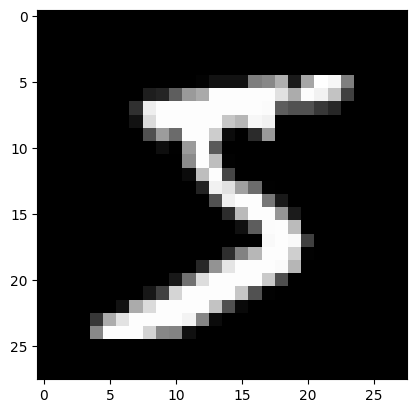

In [23]:
with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

# RNN with nested/list inputs
This is what I'm doing: each timestep has a nested/list/dict like structure

Need a custom cell/layer for this.
Subclassing Tutorial: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

**Personal Note**: This seems to require a lot of knowledge on the theory of ML, so I may leave this for later.

In [24]:
@keras.saving.register_keras_serializable()
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super().__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}

In [25]:
# Building the model
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

In [26]:
# Training model with randomly generated data
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 12s 1s/step - loss: 0.7438 - rnn_1_loss: 0.2789 - rnn_1_1_loss: 0.4650 - rnn_1_accuracy: 0.0891 - rnn_1_1_accuracy: 0.0334


# Time Series Forecasting Tutorial
https://www.tensorflow.org/tutorials/structured_data/time_series

In [3]:
# Importing things again (there is a lot for this one)
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Preprocessing the Data

The Data used: Weather time series.

14 features, collected every 10 minutes from 2003. Will be using data from 2009-2016

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


Will be making hourly predictions, will subsample from the data (from 10 minutes to 1 hour samples)

In [5]:
df = pd.read_csv(csv_path)
# Start from index 5, take every 6th record
df = df[5::6]

date_time = pd.to_datetime(df.pop("Date Time"), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


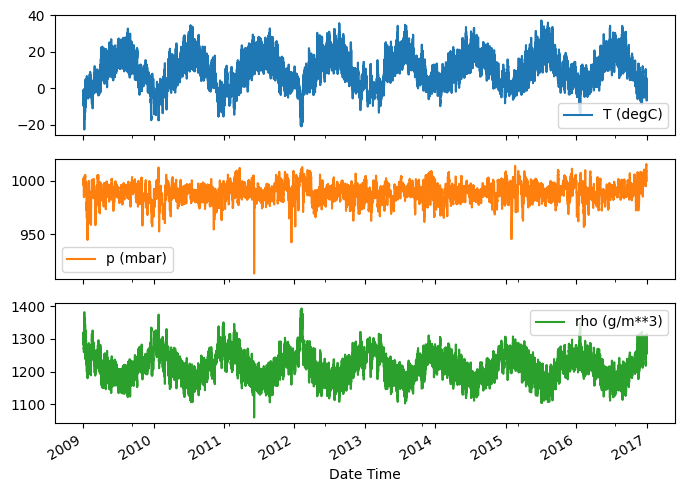

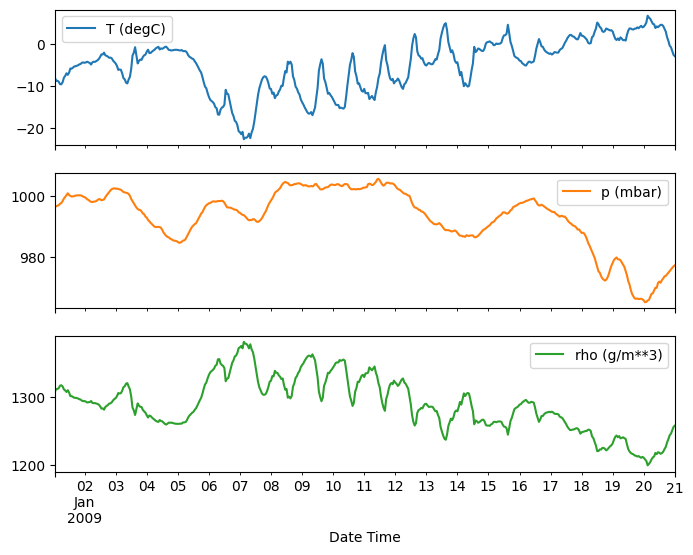

In [6]:
# Plotting evolution for a couple features
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Will now inspect and clean the dataset

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [8]:
# Noticing the odd values (-9999.00)
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
wv[bad_max_wv] == 0.0

# Checking that it works
df['wv (m/s)'].min()

0.0

Now we need to process some of the data

Text(0, 0.5, 'Wind Velocity [m/s]')

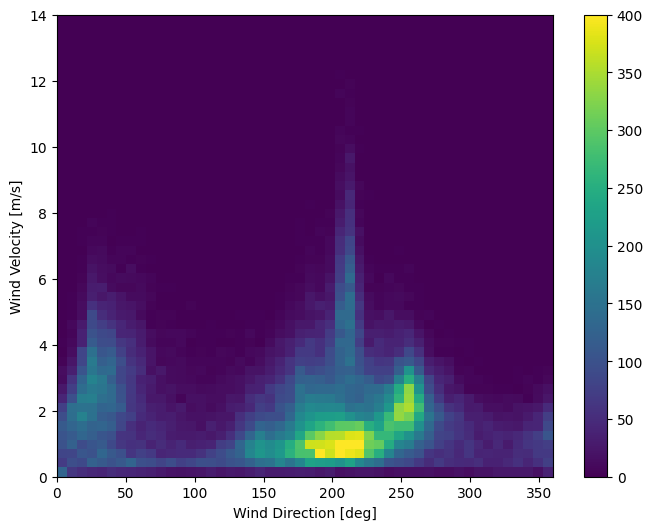

In [9]:
# Wind direction needs to wrap around: 360 deg and 0 deg should be the same
# Wind direction current distribution
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Convert the wind speed and wind direction into a vector using simple geometry.

In [10]:
# Combine the degree and speed into one vector
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

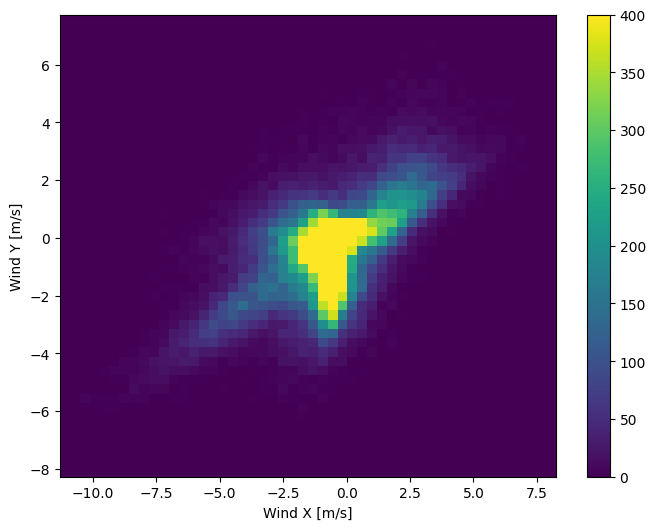

In [11]:
# Much easier to visualize.
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Now converting the `Date Time` column into seconds.

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Furthermore, to match the periodicity of weather, will use the Time of Day and Time or Year. This is under the knowledge that the frequency is years and days.

If you don't know the frequency of your data, just use FFT (fast fourier transform).

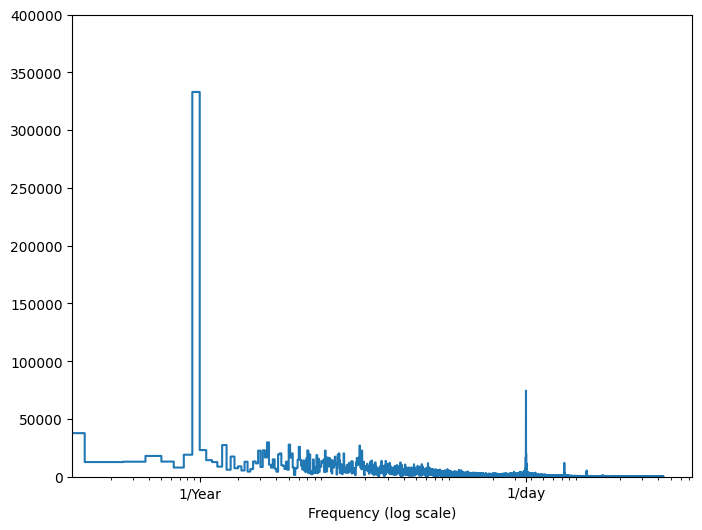

In [13]:
# Double Checking the frequency
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [14]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

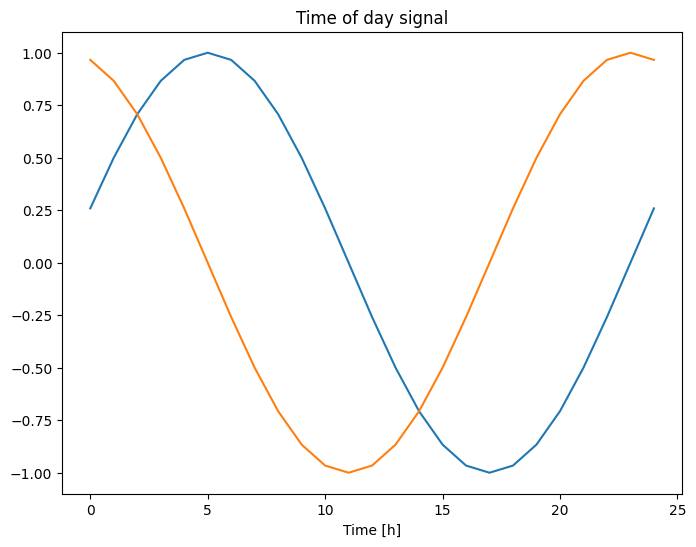

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Splitting the data now using 70% training, 20$ validation, 10% test set.

No shuffling because:
1. We need to chop data into windows of consecutive samples
2. Validation/test results are more realistic because it is being tested on data that came after what it was trained on.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Normalizing the Data

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Quick look at the features

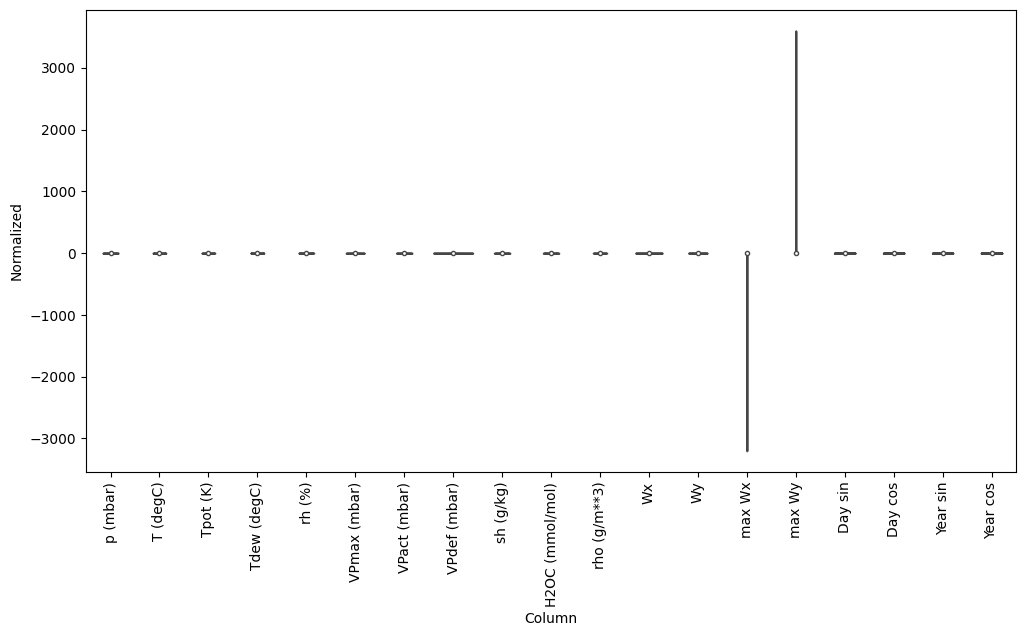

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Windowing the data

3 main features:
1. Width
2. Time offset
3. Which features are used as inputs, labels, or both

Depending on what you do, you will window the data differently.

Will create a `WindowGenerator` class for generalizing.
Goal:
1. Handle different indexes and offsets of the window
2. Split windows into `(features, labels)` pairs
3. Plot the contents of resulting windows
4. Efficiently generate batches of windows from training, evaluation, and test data

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  # Will split the inputs and labels of the features based on initial parameters
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Window Examples:

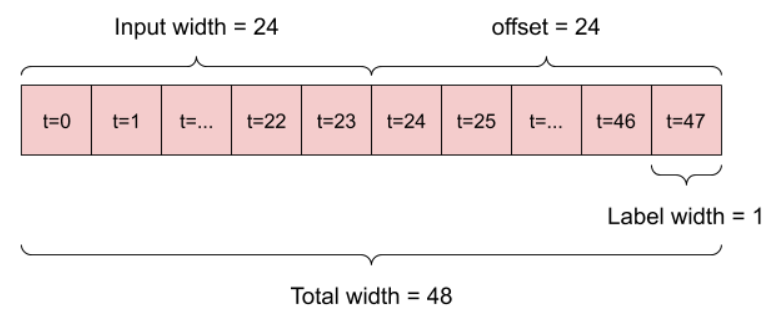

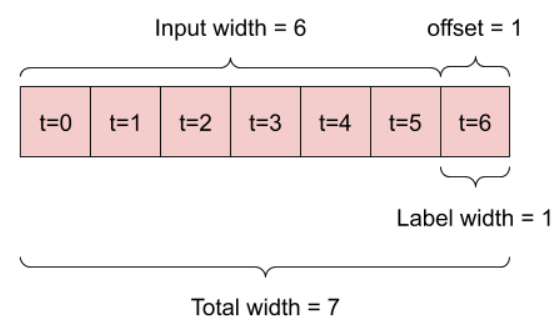


In [20]:
# Examples
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
print(w1, '\n\n', w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)'] 

 Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']


In [21]:
# Checking slicing functionality

# Here, we are splitting 3 windows into two halves of one with 6 elements and one with 1 element.
# THe label we are trying to predict will only have 1 feature because it was initialized with label_columns of length 1
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [22]:
# Won't work after setting @property example
# # Plotting
# w2.example = example_inputs, example_labels

# # With the window + label
# w2.plot()

# # Other features (without label)
# w2.plot(plot_col='p (mbar)')

In [23]:
# Creating the datasets# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [24]:
# Making concrete batches
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Forecasting Single time step

### Single Feature Forecasting

Will be predicting a single feature's value 1 time step into the future (1 hour).

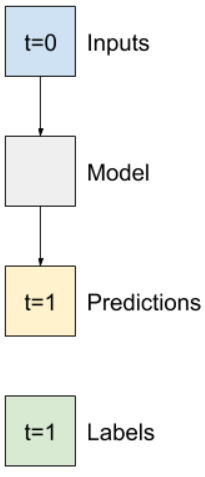

In [25]:
# Creating the windows
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [26]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


The following is predicting temperature one hour into the future given all current features.

Need a baseline to compare future models to. This baseline will simply predict that the future temperature is the same.

In [27]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [28]:
# Instantiating and evaluating the model.
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [29]:
# Plotting to better visualize perforamnce
# Need a wider window
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

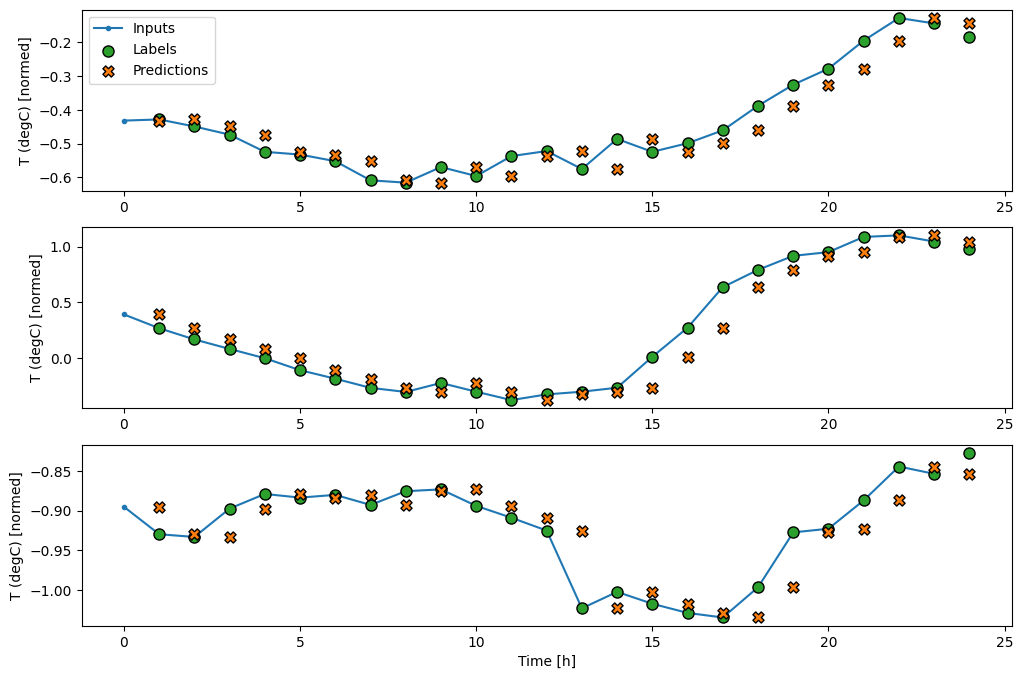

In [30]:
# Here, we can see that the model is really just a shifted version of the curve
wide_window.plot(baseline)

Function to train models.

In [31]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#### Simplest Training Model
A linear model that only takes into account the current state.

Simply use a dense layer.

In [32]:
# Creating a linear model
linear = keras.Sequential(
    layers.Dense(units=1)
)

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.1088 - mean_absolute_error: 0.2037 - val_loss: 48.6713 - val_mean_absolute_error: 0.1774
Epoch 2/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0761 - val_loss: 11.4125 - val_mean_absolute_error: 0.1065
Epoch 3/20
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0715 - val_loss: 1.4415 - val_mean_absolute_error: 0.0847
Epoch 4/20
1534/1534 [==============================] - 15s 10ms/step - loss: 0.0093 - mean_absolute_error: 0.0705 - val_loss: 0.0162 - val_mean_absolute_error: 0.0722
Epoch 5/20
1534/1534 [==============================] - 15s 10ms/step - loss: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.4300 - val_mean_absolute_error: 0.0804
Epoch 6/20
439/439 [==============================] - 2s 4ms/step - loss: 1.0661 - mean_absolute_error: 0.0869


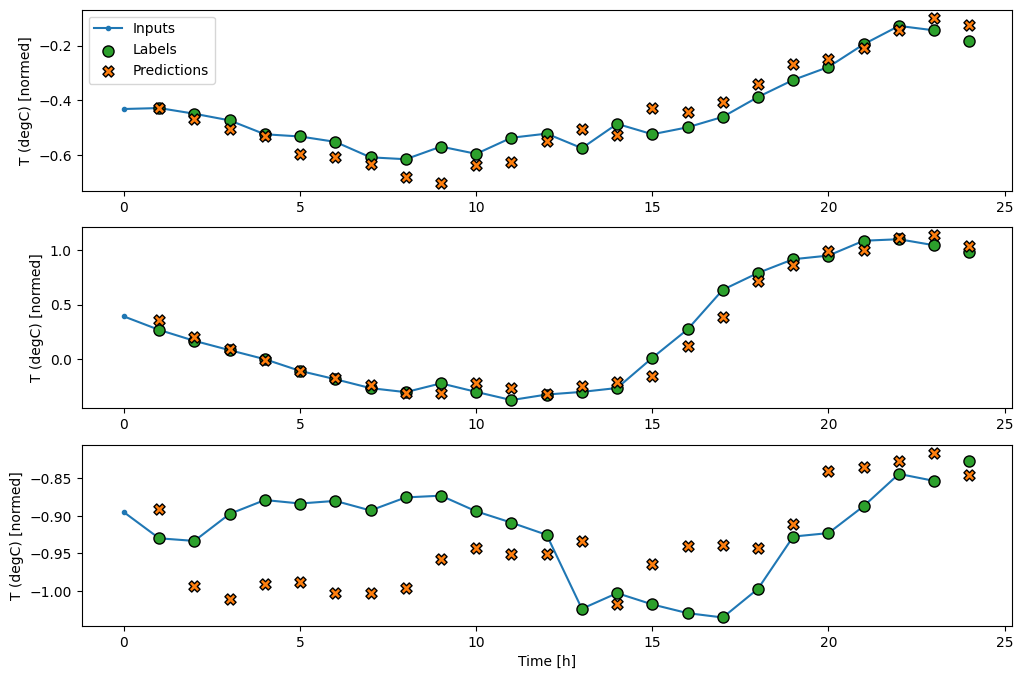

In [33]:
# Again, using the wide window to better visualize
wide_window.plot(linear)

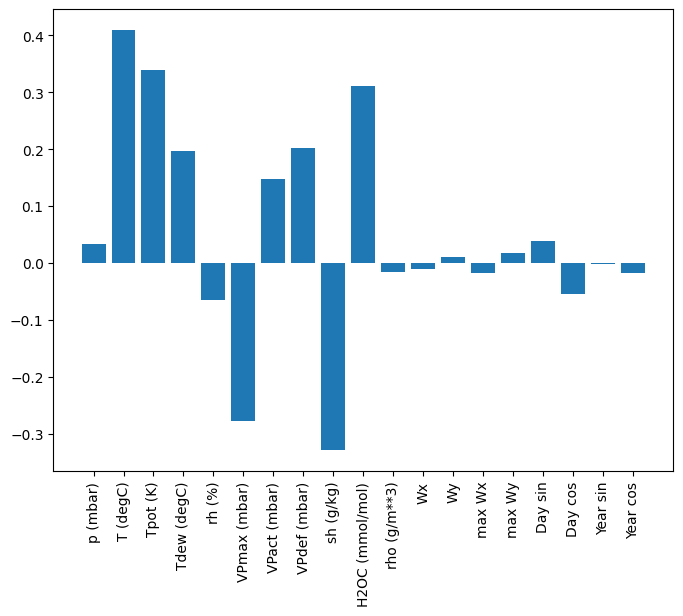

In [34]:
# Visualizing the weights to analyze the correlations.
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Denser Model

In [35]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 11s 6ms/step - loss: 0.0183 - mean_absolute_error: 0.0810 - val_loss: 13.5873 - val_mean_absolute_error: 0.1238
Epoch 2/20
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0078 - mean_absolute_error: 0.0638 - val_loss: 0.8540 - val_mean_absolute_error: 0.0778
Epoch 3/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0074 - mean_absolute_error: 0.0618 - val_loss: 0.3872 - val_mean_absolute_error: 0.0667
Epoch 4/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0544 - val_mean_absolute_error: 0.0615
Epoch 5/20
1534/1534 [==============================] - 15s 10ms/step - loss: 0.0069 - mean_absolute_error: 0.0594 - val_loss: 0.4948 - val_mean_absolute_error: 0.0756
Epoch 6/20
439/439 [==============================] - 2s 4ms/step - loss: 0.6110 - mean_absolute_error: 0.0705


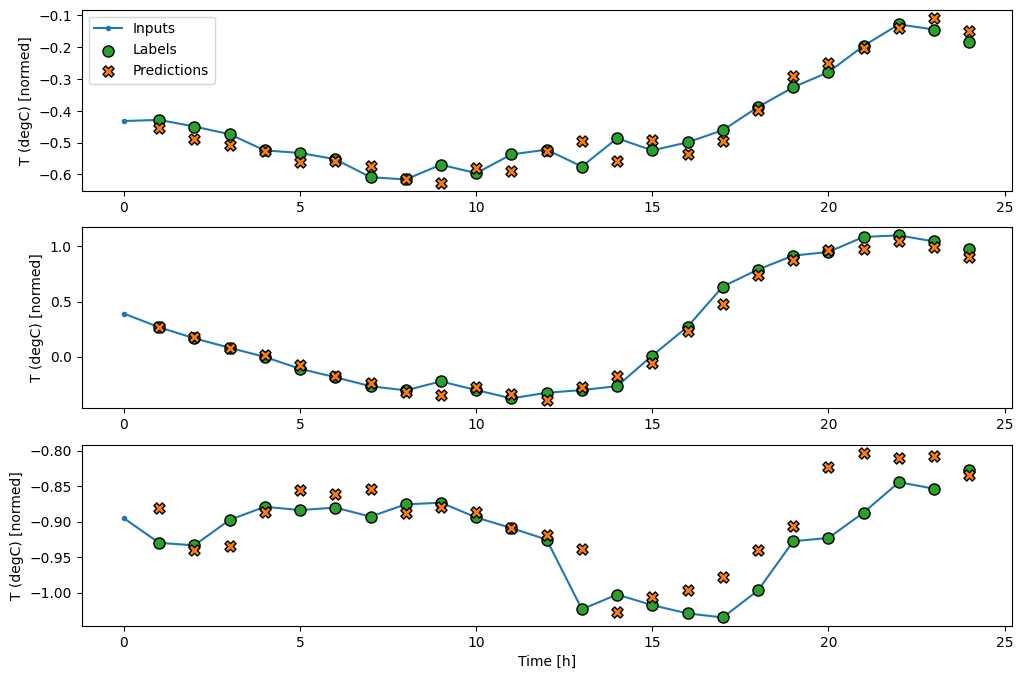

In [36]:
# Plotting to see performance
wide_window.plot(dense)

#### Multi-step Dense Model
Takes into account more time steps.

Drawback: can only execute on windows of exactly this shape. Therefore, we cant really compare to the other models in the wide window.

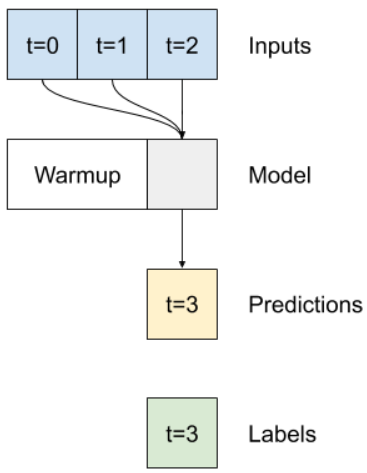

In [37]:
# Make a new window that has batches of 3 hour inputs and 1 hour labels
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

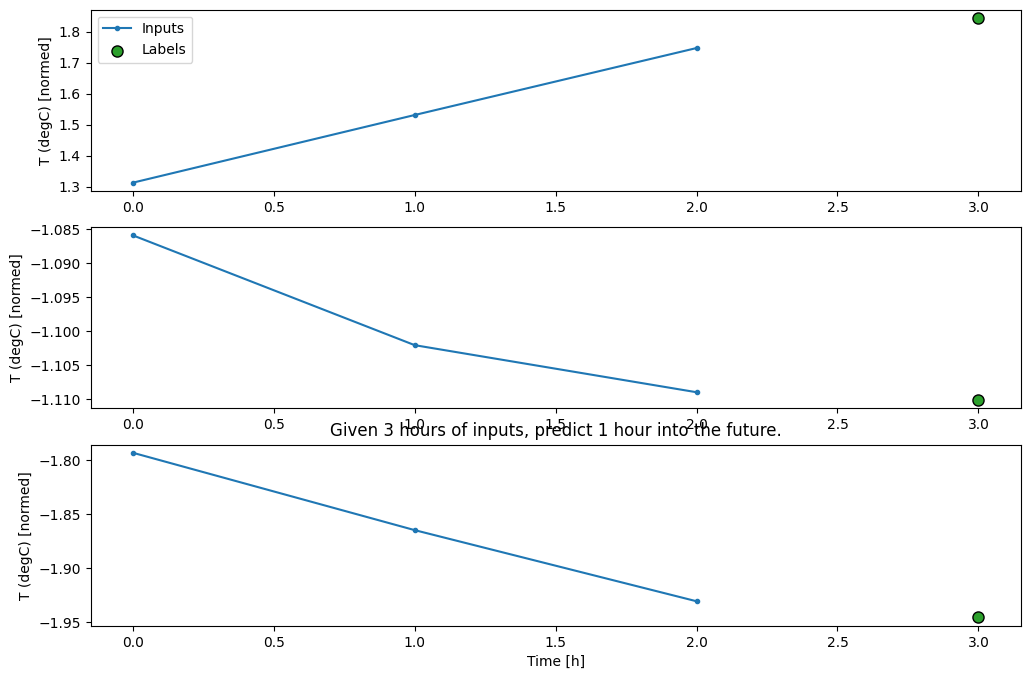

In [38]:
# Plots
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [39]:
# Creating a multi-step using a flatten layer
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [40]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 7.1290 - mean_absolute_error: 0.1122


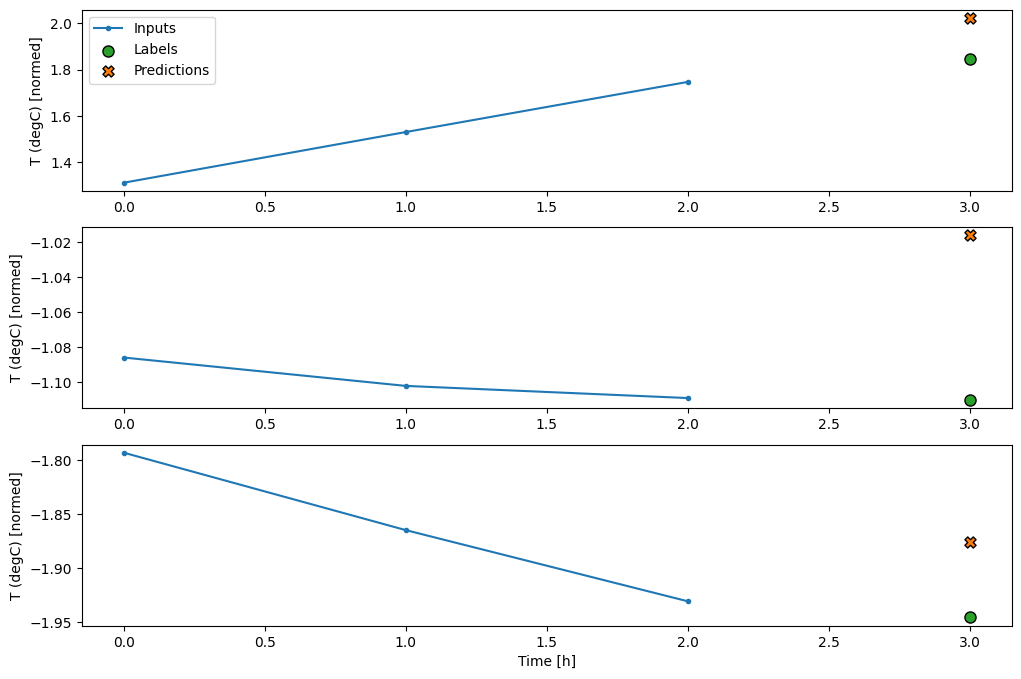

In [41]:
conv_window.plot(multi_step_dense)

#### Convloutional Neural Network

Can work on inputs of any size/length because the convolutional filter is like a silding window.

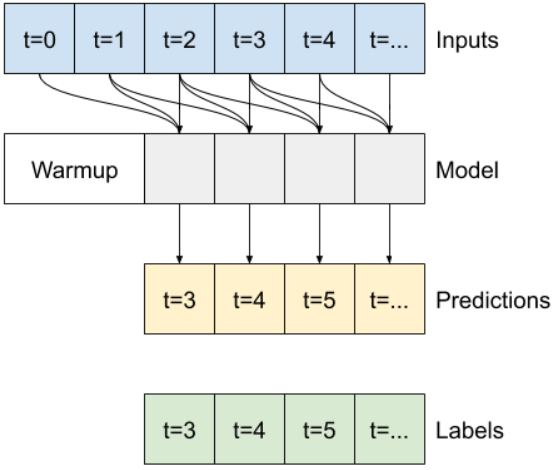

In [42]:
conv_model = tf.keras.Sequential([
    # This layer replaces the first Dense and Flatten layer
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

# Able to work on a wide window
print()
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [43]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 3s 8ms/step - loss: 4.1163 - mean_absolute_error: 0.0970


In [44]:
# Testing on a wider window, but need to supply more inputs to match the label length with the output length.
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

print(wide_conv_window)
print()
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


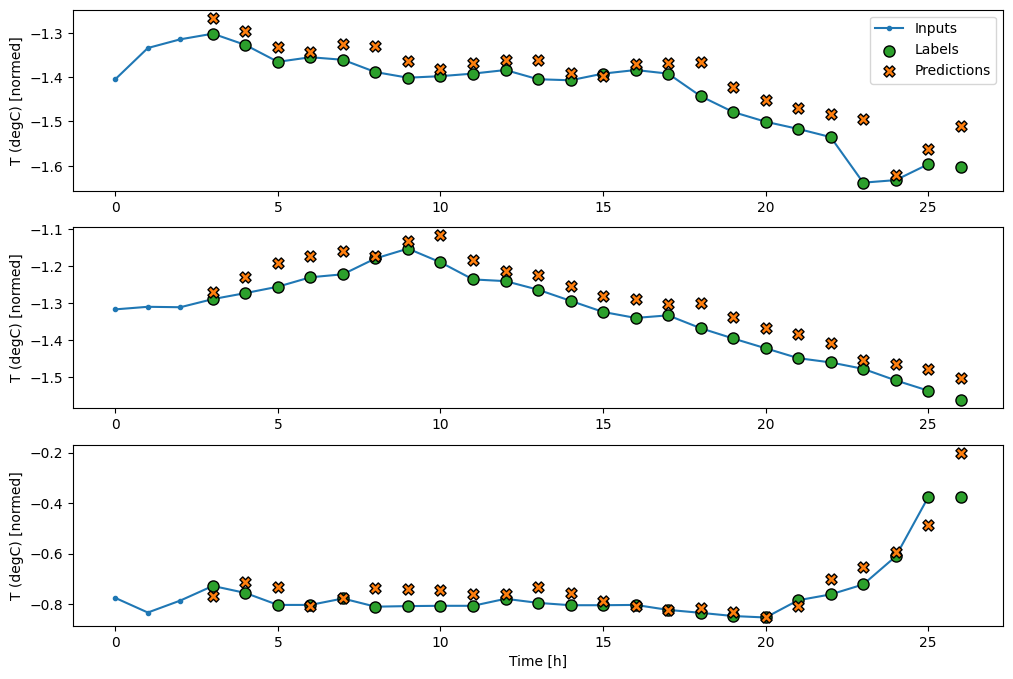

In [45]:
# Plotting
wide_conv_window.plot(conv_model)

#### Recurrent Neural Networks/LSTM

DOesn't need a wider window.

The way the `return_sequences` works is:
1. False would mean it only returns one output at the very end.
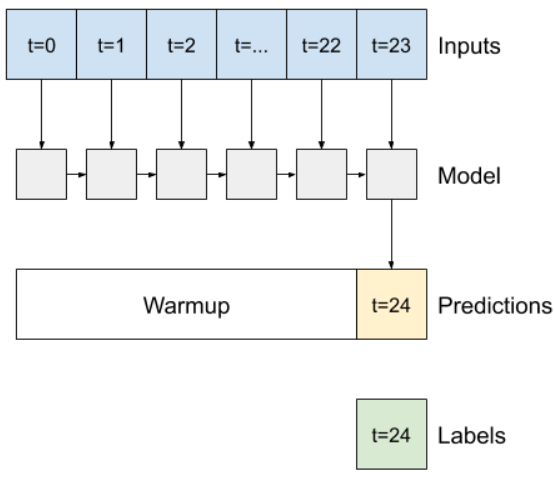

2. If True, then a prediction is made for each time step. Useful for:
  * stacking RNN layers (denser model)
  * training the model on multiple time steps simultaneously.
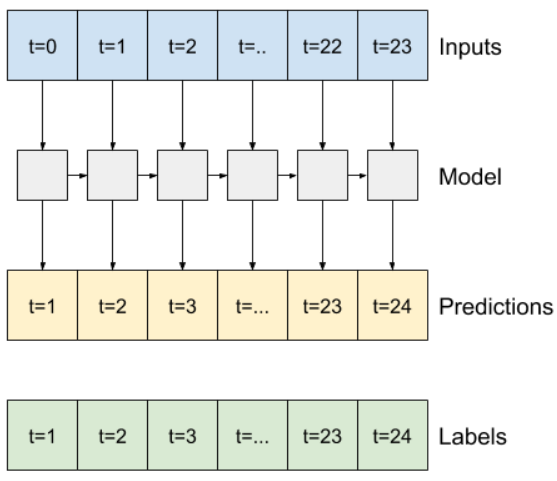

In [46]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [47]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 6s 14ms/step - loss: 0.0064 - mean_absolute_error: 0.0518


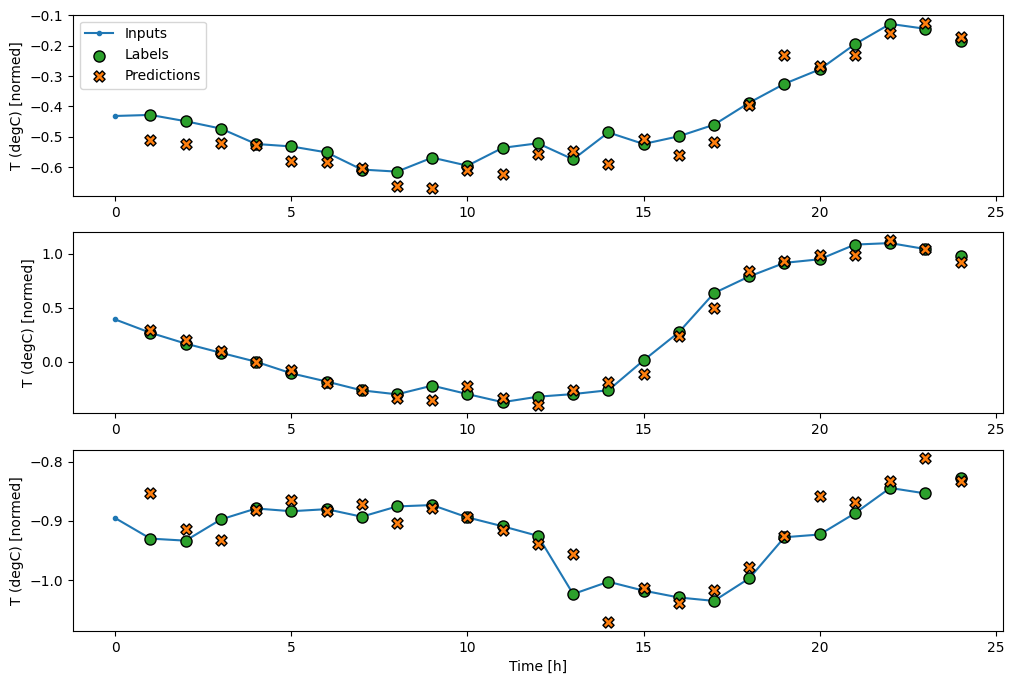

In [48]:
wide_window.plot(lstm_model)

#### Comparing all models

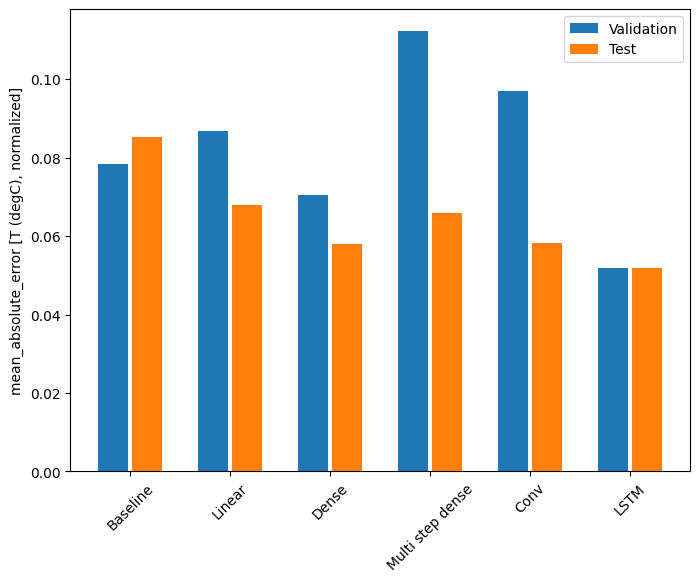

In [49]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [50]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0679
Dense       : 0.0581
Multi step dense: 0.0659
Conv        : 0.0582
LSTM        : 0.0519


### All feature forecasting

In [51]:
# Creating a new set of windows that will have the models predicting all outputs
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


#### Baseline

In [52]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [53]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 156.7263 - mean_absolute_error: 0.2100


#### Dense Model

In [54]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [55]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 5ms/step - loss: 146.3589 - mean_absolute_error: 0.2330


#### RNN/LSTM

In [56]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 4s 8ms/step - loss: 168.3395 - mean_absolute_error: 0.1775

CPU times: user 3min 7s, sys: 10.2 s, total: 3min 17s
Wall time: 2min 58s


#### Residual Connections

The time series doesn't change that much, so the baseline does pretty well.

Each model, however, has to learn that at each time step the data doesn't change a lot. This is attributed to the fact that it is randomly initialized (weights are random).

Sometimes models can predict the change in a feature rather than a new value; this is called a Residual network (ResNet). Each layer adds to the model's accumulating results. We can use this model to let it know that the changes are small. We start off with the baseline model.

The only difference that this makes is faster training. This technique can be used for every model shown previously.

Applying the residual concept to the LSTM

In [57]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [58]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 5s 10ms/step - loss: 156.6739 - mean_absolute_error: 0.1695

CPU times: user 3min 8s, sys: 10.5 s, total: 3min 18s
Wall time: 3min 37s


#### Performance

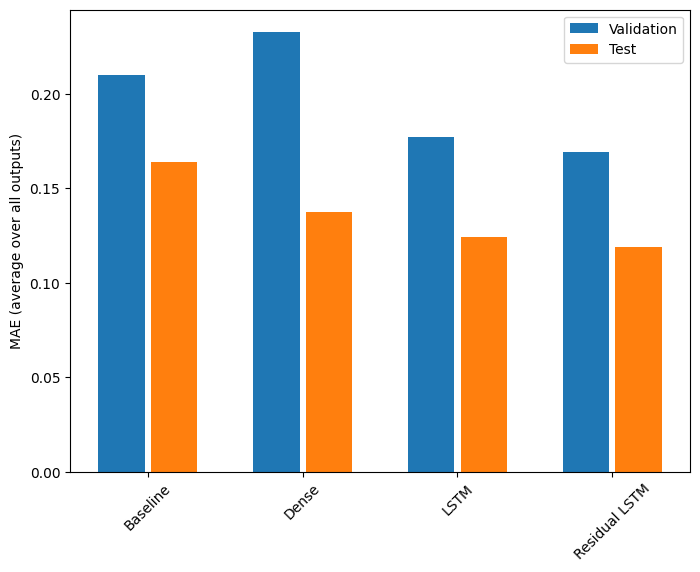

In [59]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [60]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1374
LSTM           : 0.1246
Residual LSTM  : 0.1192


## Forecasting Multiple time steps

All these models will be predicing all features at future time steps.

Visualizing the window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

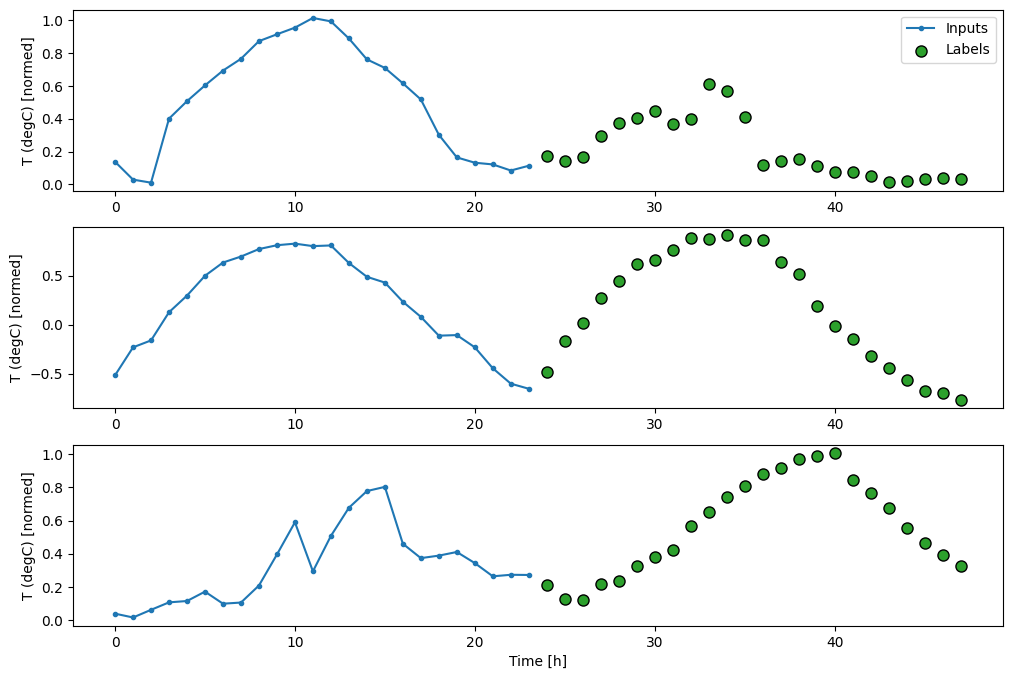

In [61]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Baseline
Repeat the last input seen for all future predictions.

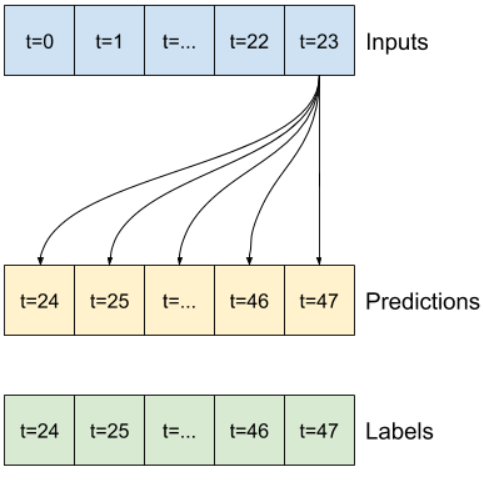

437/437 [==============================] - 2s 5ms/step - loss: 324.8779 - mean_absolute_error: 0.6044


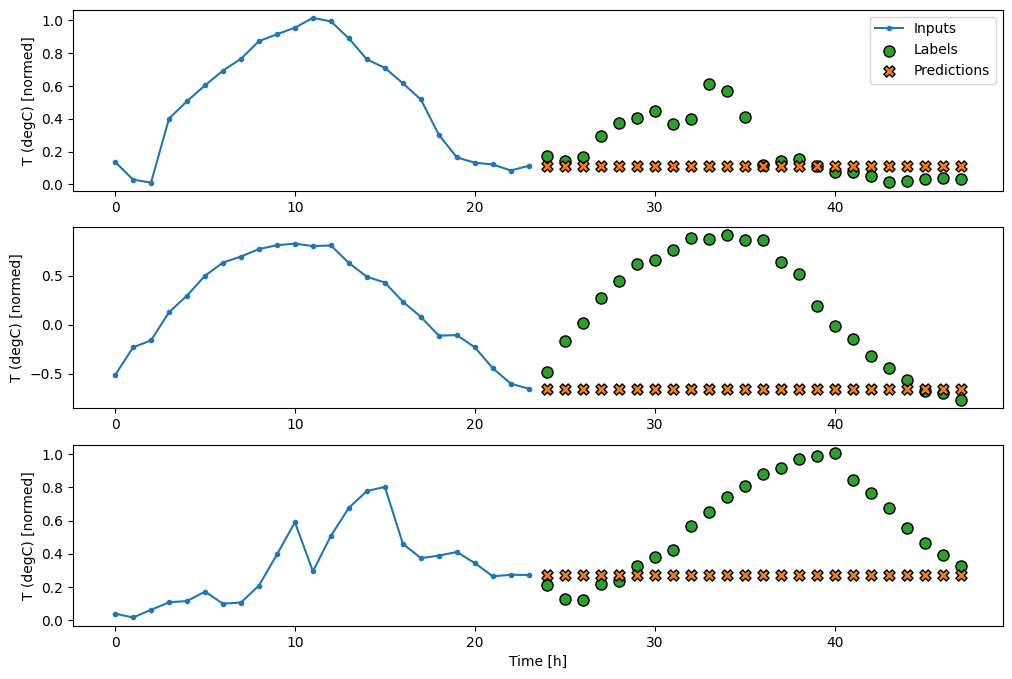

In [62]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

#### Second Baseline Approach
Repeat values 24 hours into the future (one time step used for one time stpe in the future)

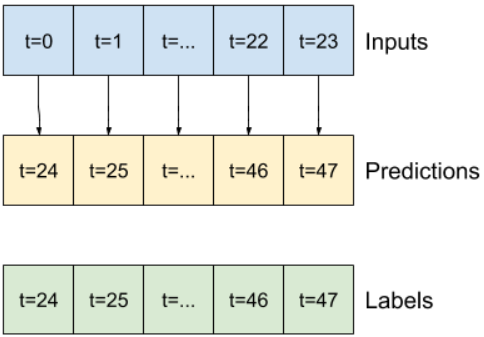

437/437 [==============================] - 3s 5ms/step - loss: 337.6465 - mean_absolute_error: 0.5036


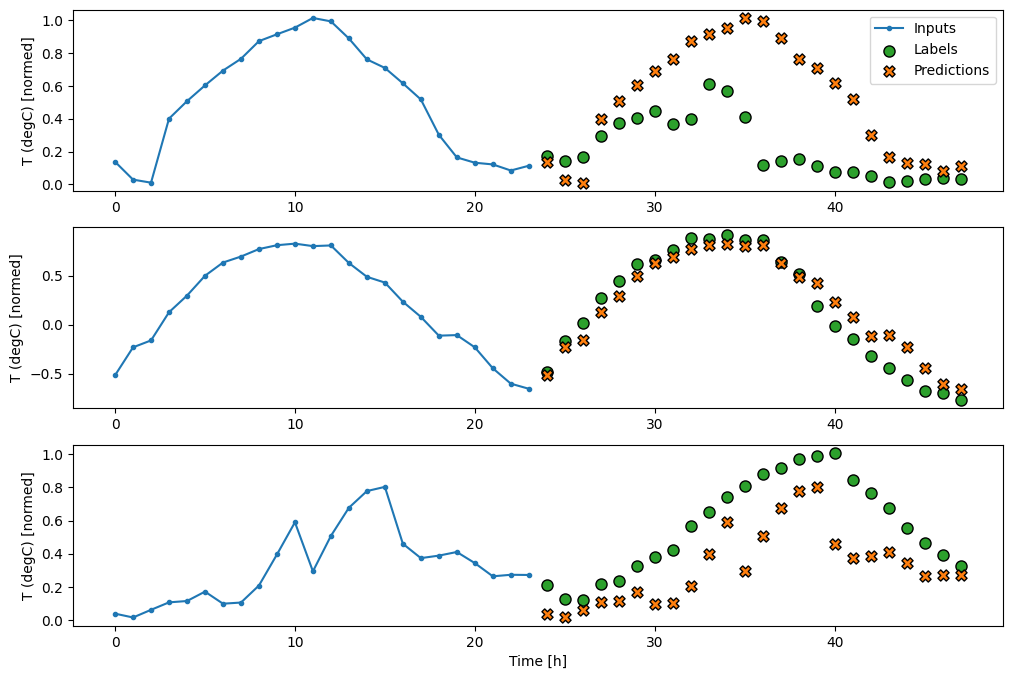

In [63]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot
Predict all the steps at once

Done with a dense layer with `OUTPUT_STEPS * features` output units, reshape it to `(OUTPUT_STEPS, features)`.

#### Linear Model
Predicts all outputs from the last step. As expected it is bad because it only captures patterns on the last day.

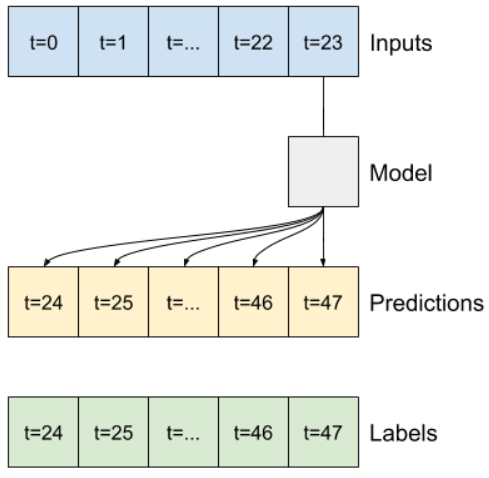

437/437 [==============================] - 2s 4ms/step - loss: 189.1864 - mean_absolute_error: 0.4162


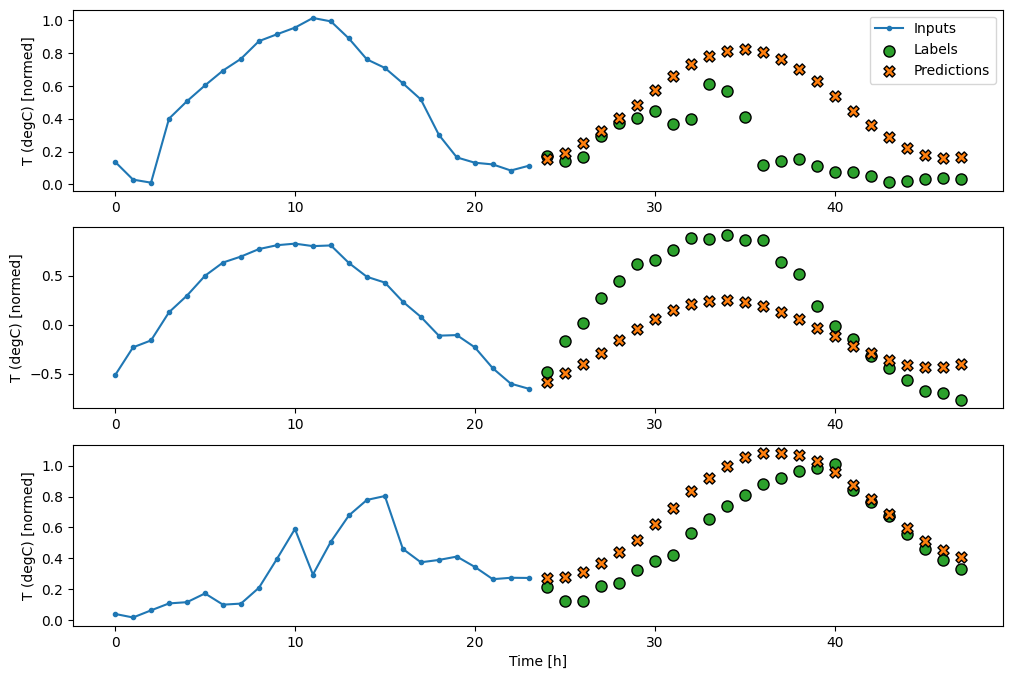

In [64]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense Model
Although more power is created from many dense layers, it is still based on a single input step.

437/437 [==============================] - 2s 5ms/step - loss: 191.5690 - mean_absolute_error: 0.3891


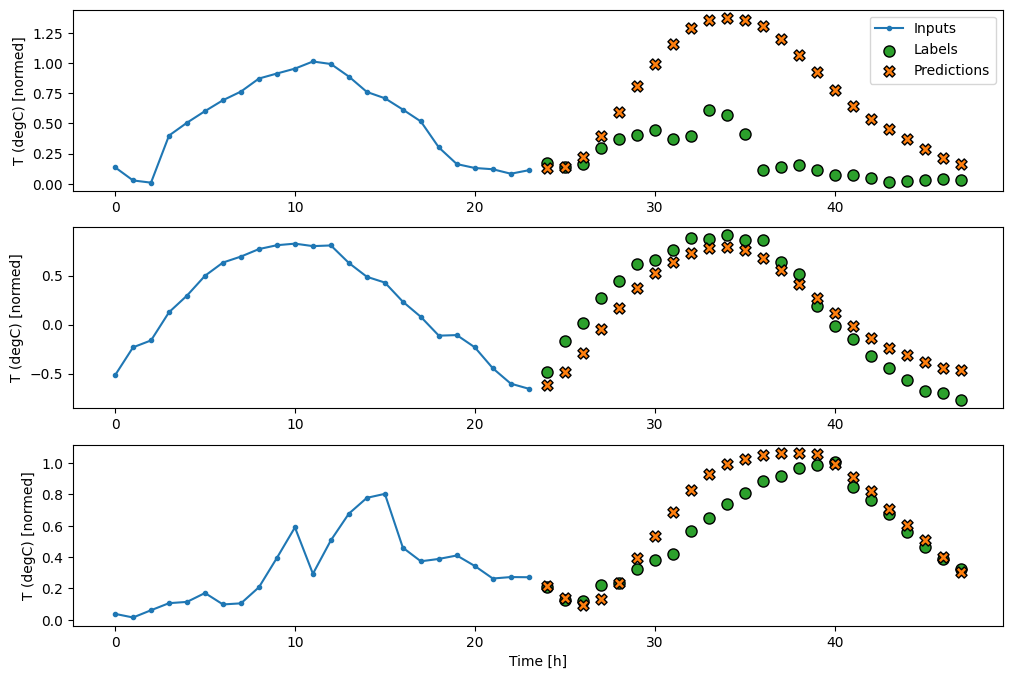

In [65]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN
Expands the input window to some fixed length, 3 in this case.

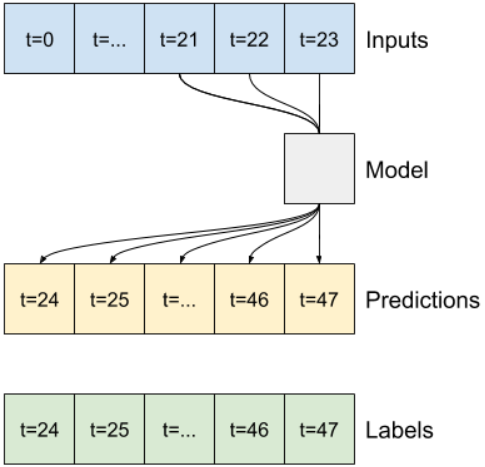

437/437 [==============================] - 2s 5ms/step - loss: 219.2250 - mean_absolute_error: 0.4478


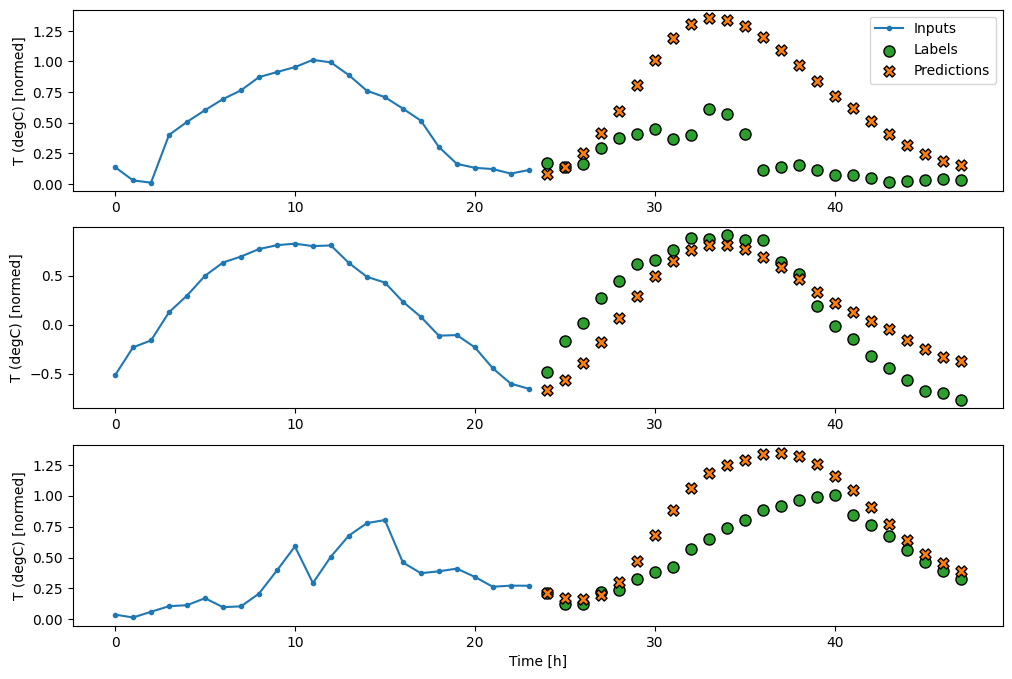

In [66]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN/LSTM
Accumulates an internal state for 24 time steps which can be used to help evaluate the future time steps.

`return_sequences=False` because only need 1 prediction.

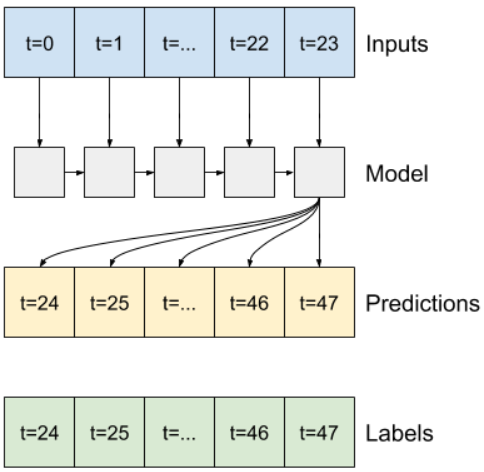

437/437 [==============================] - 4s 8ms/step - loss: 168.7824 - mean_absolute_error: 0.3408


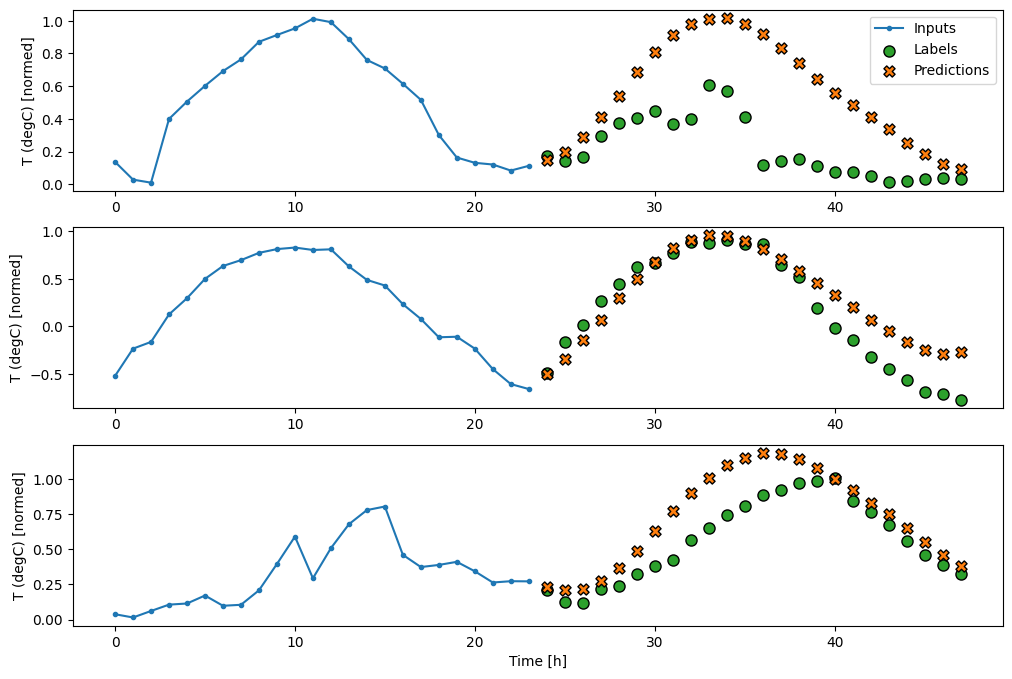

In [67]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive
Make a single prediction then feed it back to the model before making the next prediction.

This allows for variable output length.

Any model can implement this. The below will show a model that has been explicitly trained to do this.

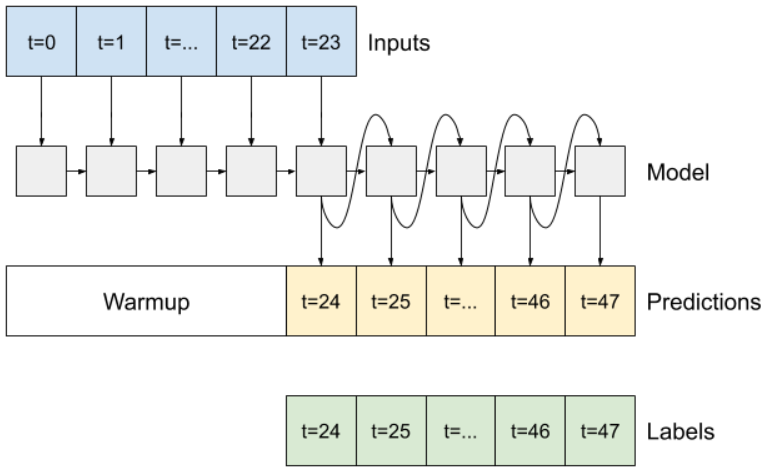

#### RNN

This will be a single step LSTM model. Will interact using LSTMCell for greater control over the inputs.

In [71]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  # Trains the model on the input data to get an internal state ready for prediction.
  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

In [72]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [75]:
# Returns a single time-step prediction and internal state of LSTM
# Here, we see the shape is a size 32 batch, each with 19 features.
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Just loop through a process of evaluation using a Python list and `tf.stack`

Note: stacking Python Lists only works with eager-execution (when compiling the model, set `run_eagerly=True)`. What this means is that as the model is training, there aren't any frameworks/equations that are calculated later: they are calculated on the spot (specifically the Tensors). It also works with a fixed length output.

If you have a dynamic output length, you will need to use `tf.TensorArray` and `tf.range` instead of Python lists and range.

In [76]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [77]:
# Test running
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


437/437 [==============================] - 5s 10ms/step - loss: 168.7968 - mean_absolute_error: 0.3609


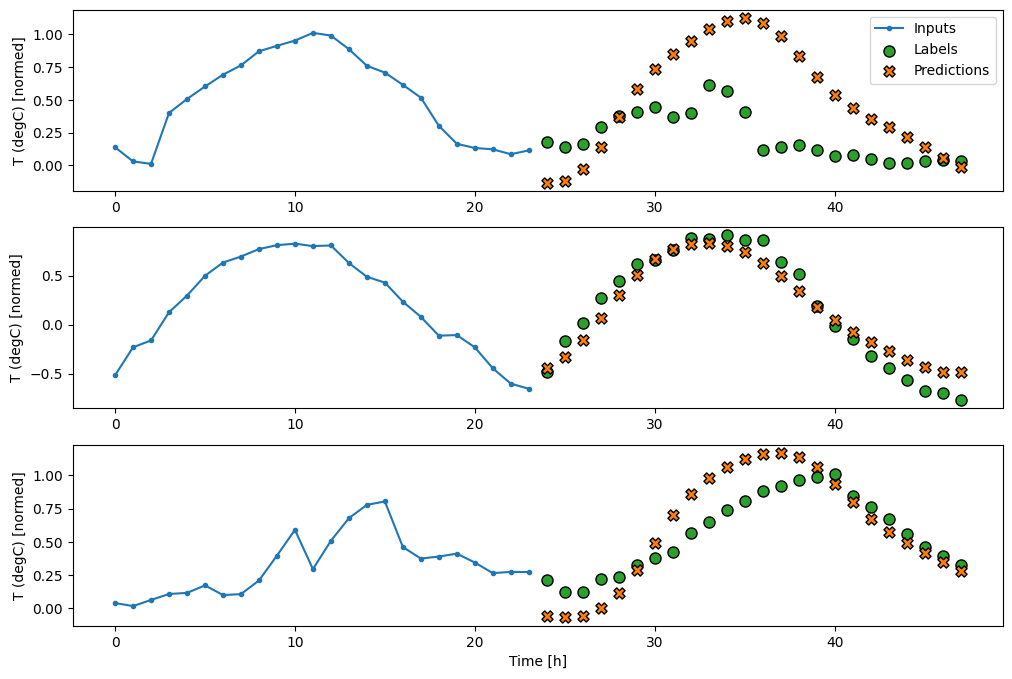

In [78]:
# Training
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

#### Performance
Diminishing returns when increasing complexity.

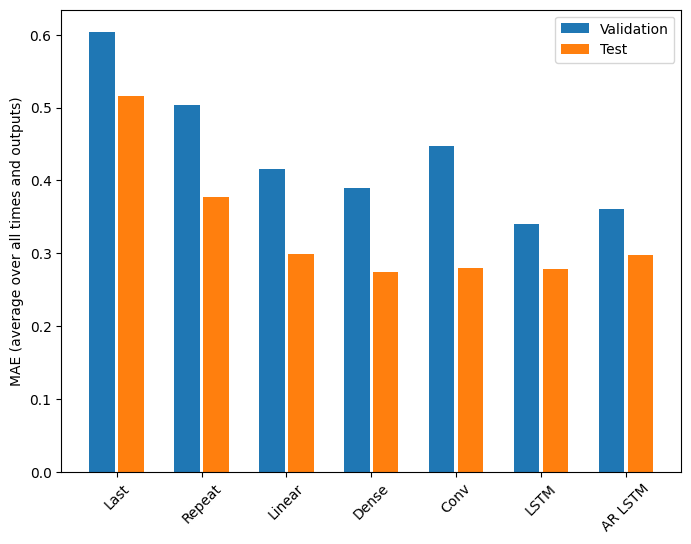

In [79]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [80]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2990
Dense   : 0.2739
Conv    : 0.2790
LSTM    : 0.2788
AR LSTM : 0.2974
